### data prep

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, make_scorer

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [4]:
# load the data
file_url = 'https://archive.ics.uci.edu/static/public/222/data.csv'
df = pd.read_csv(file_url)

# convert target var to numerical
df.y = df.y.map({'yes':1,'no':0})

# fill na
df.fillna('unknown', inplace=True)

# drop duration
df.drop('duration', axis=1, inplace=True)

# split the data into train/val/test with 60%/20%/20%
df_full, df_test = train_test_split(df, test_size=np.round(len(df)*.2).astype(int), random_state=42)
df_train, df_val = train_test_split(df_full, test_size=np.round(len(df)*.2).astype(int), random_state=42)

In [5]:
num = ['age','balance','day_of_week','campaign','pdays','previous']
cat = ['job','marital','education','default','housing','loan','contact','month','poutcome']
features = cat+num

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

df_train=df_train.to_dict(orient='records')
df_val=df_val.to_dict(orient='records')
df_test=df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(df_train)

X_train = dv.transform(df_train)
X_val = dv.transform(df_val)
X_test = dv.transform(df_test)

### model definition

In [6]:
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

models_dict = {
    'Logistic Regression': lr_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

/home/minasonbol/Documents/study/mleng-zoomcamp/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### model assessment on validation data

In [7]:
# Define a function for model evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    return accuracy, precision, recall, f1, roc_auc

In [8]:
def confusion_matrix_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    return cm

#### metric scores

In [9]:
metrics = ('Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC')

for model in models_dict:
    print(f"Metrics for {model}:")
    scores = evaluate_model(models_dict[model], X_val, y_val)
    for metric, score in zip(metrics, scores):
        print(f"{metric}: {score}")
    print("\n")

Metrics for Logistic Regression:
Accuracy: 0.8852023888520238
Precision: 0.65
Recall: 0.024761904761904763
F1-score: 0.047706422018348627
ROC AUC: 0.5115050765050765


Metrics for Decision Tree:
Accuracy: 0.8261446582614466
Precision: 0.28536184210526316
Recall: 0.3304761904761905
F1-score: 0.30626654898499556
ROC AUC: 0.6108712283712283


Metrics for Random Forest:
Accuracy: 0.8918380889183809
Precision: 0.5895522388059702
Recall: 0.2257142857142857
F1-score: 0.3264462809917355
ROC AUC: 0.6025343200343201


Metrics for XGBoost:
Accuracy: 0.8909533289095333
Precision: 0.5655737704918032
Recall: 0.26285714285714284
F1-score: 0.35890767230169046
ROC AUC: 0.6181653081653081




#### confusion matrix

Confusion matrix for Logistic Regression:


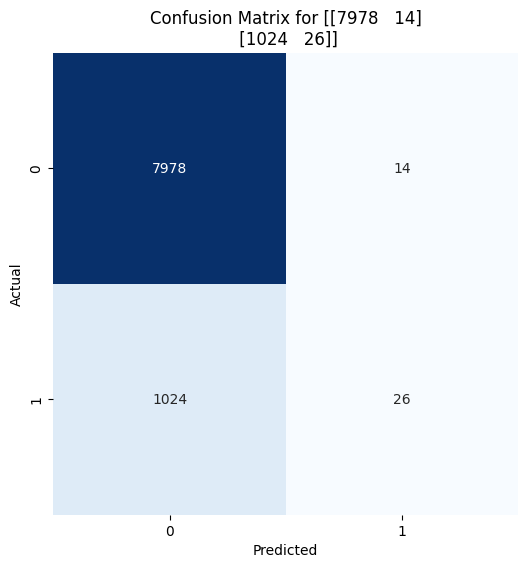

Confusion matrix for Decision Tree:


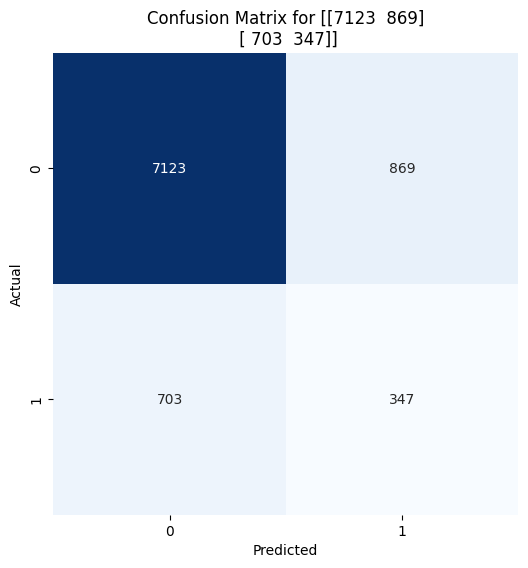

Confusion matrix for Random Forest:


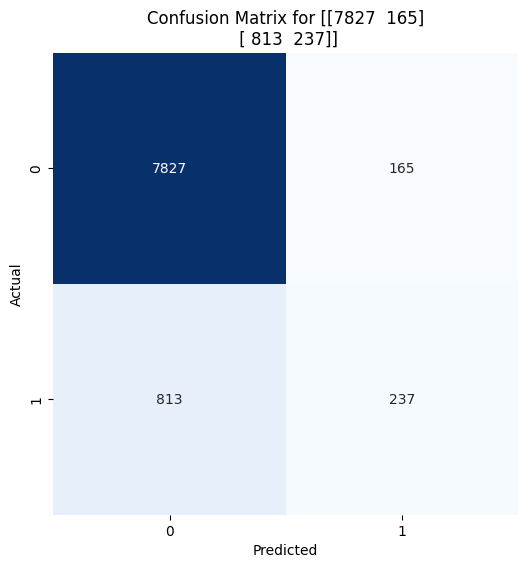

Confusion matrix for XGBoost:


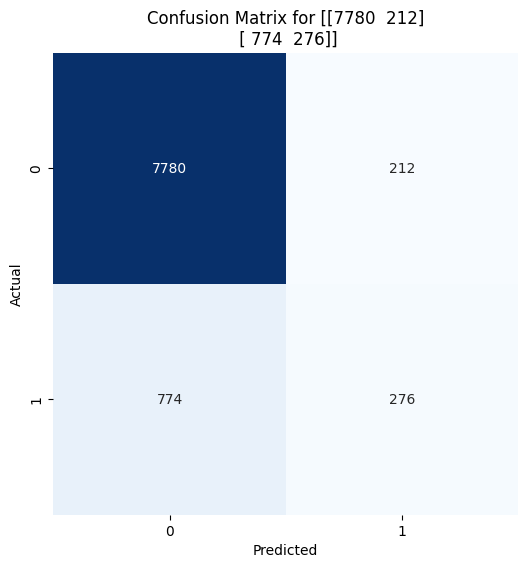

In [10]:
for model in models_dict:
    print(f"Confusion matrix for {model}:")
    cm = confusion_matrix_evaluation(models_dict[model], X_val, y_val)
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {cm}')
    plt.show()

#### choosing which models to tune

first, the bank is prioritizing generating revenue over regulating spending, and is willing to take more risk with the marketing campaign to achieve that goal. 

second, let's illustrate the implications of the model making wrong predictions:

when the model mistakenly predicts 1 instead of 0 it's money lost by the bank  
when the model mistakenly predicts 0 instead of 1 it's a missed opportunity for the bank to make a profit   

now, let's consider each of our evaluation metrics and see how they fit with the above:

for this project the data is imbalanced, so the accuracy metric can be confusing, as a high accuracy score can be achieved by overcompensating on the dominant class. 

therefore, we will focus on precision, recall, f1, and roc auc. 

precision: tp / (tp + fp) "Of all the instances the model labeled as positive, how many were actually positive?", i.e. low precision = lost money. given the bank's strategy, precision will take a lower priority than the other metrics.

recall: tp / (tp + fn) "Of all the instances that were actually positive, how many did the model correctly identify?", i.e. low recall = missed opportunity. given the bank's strategy, recall will take a higher priority than the other metrics.

f1 is a composite of precision and recall 

roc auc is ...

decision trees have the highest recall, followed by xgboost

both models also have the highest f1 and roc auc scores.

accordingly, in the next phase we'll focus on these 2 models only. in the next section, we tune their respective hyperparameters, then we decide which model we'll ship into production.

### hyperparameter tuning

#### decision tree hyperparameter tuning

In [11]:
# Set up the parameter grid
param_grid = {
    'max_depth':[1, 2, 3, 4, 5, 6, 10, 15, 20, 25, 30, 35],
    'min_samples_leaf': [1, 5, 10, 15, 20, 500, 100, 200]
}

# Create the model
dt_model = DecisionTreeClassifier()

# Set up KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Specify multiple scoring metrics
scoring = {
    'precision': make_scorer(precision_score, average='micro'),
    'recall': make_scorer(recall_score, average='micro'),
    'f1': make_scorer(f1_score, average='micro'),
    'roc_auc': make_scorer(roc_auc_score, average='micro', multi_class='ovr')
}

# Perform grid search with cross-validation using multiple scoring metrics
dt_grid_search = GridSearchCV(dt_model, param_grid, cv=kf, scoring=scoring, refit='roc_auc')
dt_grid_search.fit(X_val, y_val)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 10, 15, 20, 25, 30,
                                       35],
                         'min_samples_leaf': [1, 5, 10, 15, 20, 500, 100, 200]},
             refit='roc_auc',
             scoring={'f1': make_scorer(f1_score, average=micro),
                      'precision': make_scorer(precision_score, average=micro),
                      'recall': make_scorer(recall_score, average=micro),
                      'roc_auc': make_scorer(roc_auc_score, average=micro, multi_class=ovr)})

In [13]:
# Print the best parameters and best scores for each metric
print("Best parameters: ", dt_grid_search.best_params_)
print("Best precision score: ", dt_grid_search.cv_results_['mean_test_precision'][dt_grid_search.best_index_])
print("Best recall score: ", dt_grid_search.cv_results_['mean_test_recall'][dt_grid_search.best_index_])
print("Best f1 score: ", dt_grid_search.cv_results_['mean_test_f1'][dt_grid_search.best_index_])
print("Best roc_auc score: ", dt_grid_search.cv_results_['mean_test_roc_auc'][dt_grid_search.best_index_])

Best parameters:  {'max_depth': 20, 'min_samples_leaf': 1}
Best precision score:  0.8650745779460612
Best recall score:  0.8650745779460612
Best f1 score:  0.8650745779460612
Best roc_auc score:  0.6121052912889212


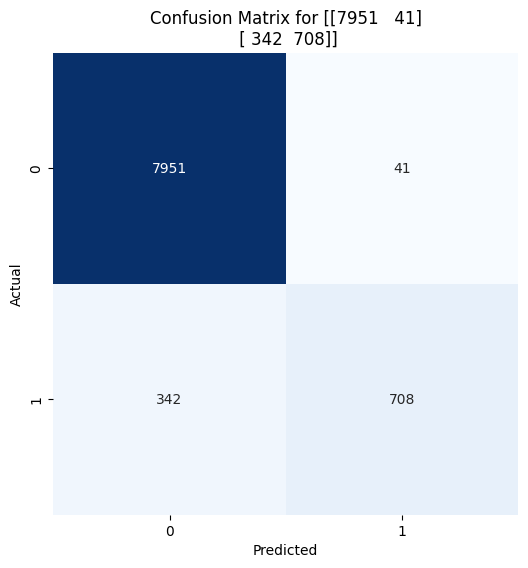

In [15]:
cm = confusion_matrix_evaluation(dt_grid_search, X_val, y_val)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
        xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {cm}')
plt.show()

#### xgboost hyperparameter tuning

In [16]:
# Set up the parameter grid
param_grid = {
    'eta': [0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 2, 4]
}

# Create the model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42)

# Set up KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Specify multiple scoring metrics
scoring = {
    'precision': make_scorer(precision_score, average='micro'),
    'recall': make_scorer(recall_score, average='micro'),
    'f1': make_scorer(f1_score, average='micro'),
    'roc_auc': make_scorer(roc_auc_score, average='micro', multi_class='ovr')
}

# Perform grid search with cross-validation using multiple scoring metrics
xgb_grid_search = GridSearchCV(xgb_model, param_grid, cv=kf, scoring=scoring, refit='roc_auc')
xgb_grid_search.fit(X_val, y_val)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     in...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'eta': [0.1, 0.3, 0.5], 'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 2, 4]},
             refit='roc_auc',
             scoring={'f1': make_scorer(f1_score, average=micro),
                      'precision': make_scorer(precision_score, average=micro),
                      'recall': make_scorer(recall_score, average=micro),
                      'roc_auc': make_scorer(roc_auc_score, average=micro, multi_class=ovr)})

In [18]:
# Print the best parameters and best scores for each metric
print("Best parameters: ", xgb_grid_search.best_params_)
print("Best precision score: ", xgb_grid_search.cv_results_['mean_test_precision'][xgb_grid_search.best_index_])
print("Best recall score: ", xgb_grid_search.cv_results_['mean_test_recall'][xgb_grid_search.best_index_])
print("Best f1 score: ", xgb_grid_search.cv_results_['mean_test_f1'][xgb_grid_search.best_index_])
print("Best roc_auc score: ", xgb_grid_search.cv_results_['mean_test_roc_auc'][xgb_grid_search.best_index_])

Best parameters:  {'eta': 0.5, 'max_depth': 5, 'min_child_weight': 4}
Best precision score:  0.8819951373907257
Best recall score:  0.8819951373907257
Best f1 score:  0.8819951373907259
Best roc_auc score:  0.6105734780483376


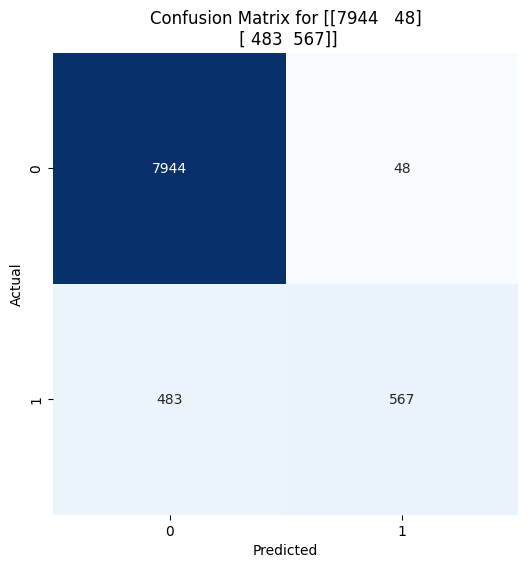

In [19]:
cm = confusion_matrix_evaluation(xgb_grid_search, X_val, y_val)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
        xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {cm}')
plt.show()

### model assessment on test data

#### decision tree

In [21]:
# Evaluate the models
dt_scores = evaluate_model(dt_grid_search, X_test, y_test)
xgb_scores = evaluate_model(xgb_grid_search, X_test, y_test)
all_scores = [dt_scores, xgb_scores]

# Compare the performances
models = ['Decision Tree', 'XGBoost']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']

for i, model in enumerate(models):
    print(f"Metrics for {model}:")
    for j, metric in enumerate(metrics):
        print(f"{metric}: {all_scores[i][j]}")
    print('\n')

Metrics for Decision Tree:
Accuracy: 0.8613138686131386
Precision: 0.3920529801324503
Recall: 0.27131072410632445
F1-score: 0.3206933911159263
ROC AUC: 0.6067910682536402


Metrics for XGBoost:
Accuracy: 0.8838752488387525
Precision: 0.5415821501014199
Recall: 0.2447296058661778
F1-score: 0.3371212121212121
ROC AUC: 0.6081527541341958




# scratch

#### thresholds

In [ ]:
thresholds = np.linspace(0, 1, 21)
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, 25, 30, 35]

scores = []

for t in thresholds:
    for depth in depths: 
        dt = DecisionTreeClassifier(max_depth=depth)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        score = f1_score(y_val, y_pred >= t)
        # print('%.2f %.2f %.3f' % (t, depth, score))
        scores.append((t, depth, score))

In [ ]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, 25, 30, 35, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    # y_pred = dt.predict_proba(X_val)[:, 1]
    # y_pred = dt.predict(X_val)
    # auc = roc_auc_score(y_val, y_pred)
    # 
    # print('%4s -> %.3f' % (depth, auc))
    # print('%4s -> %.3f' % (depth, roc_auc_score(y_val, dt.predict_proba(X_val)[:, 1])))
    # print('%4s -> %.3f' % (depth, roc_auc_score(y_val, dt.predict(X_val))))
    print(dt.predict_proba(X_val)[:, 1])

In [ ]:
scores = []

for depth in [5, 6, 10]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [ ]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f", cmap='bwr')

In [5]:
# Define a function for model evaluation
def evaluate_model_proba(model, X_test, y_test, t):
    y_pred = model.predict_proba(X_test)[:,1]
    accuracy = accuracy_score(y_test, y_pred >= t)
    precision = precision_score(y_test, y_pred >= t, zero_division=0)
    recall = recall_score(y_test, y_pred >= t)
    f1 = f1_score(y_test, y_pred >= t, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred >= t)
    return accuracy, precision, recall, f1, roc_auc

new

In [39]:
thresholds = np.linspace(0, 1, 11)

scores = []

for model in models_dict:
    for t in thresholds:
        score = evaluate_model_proba(models_dict[model], X_val, y_val, t)
        scores.append((model, t) + score)

columns = ['model', 'threshold', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot_table(index='threshold', columns='model', values=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

<Axes: xlabel='model', ylabel='threshold'>

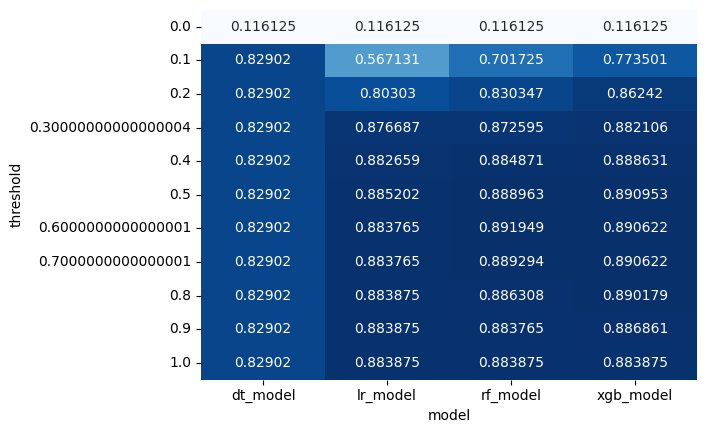

In [47]:
sns.heatmap(df_scores_pivot['accuracy'], annot=True, fmt="g", cmap='Blues', cbar=False)

<Axes: xlabel='model', ylabel='threshold'>

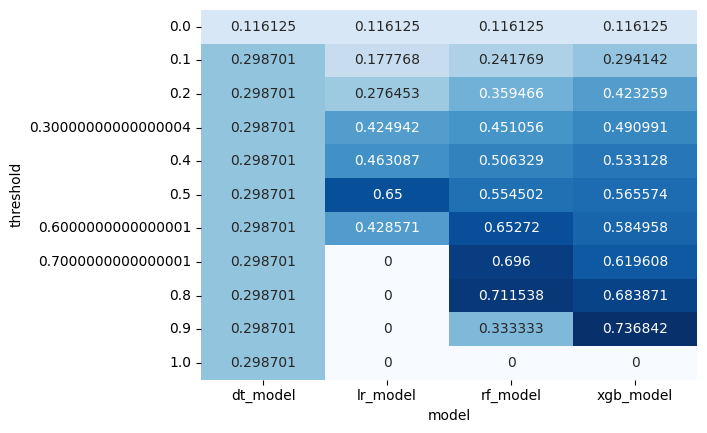

In [48]:
sns.heatmap(df_scores_pivot['precision'], annot=True, fmt="g", cmap='Blues', cbar=False)

<Axes: xlabel='model', ylabel='threshold'>

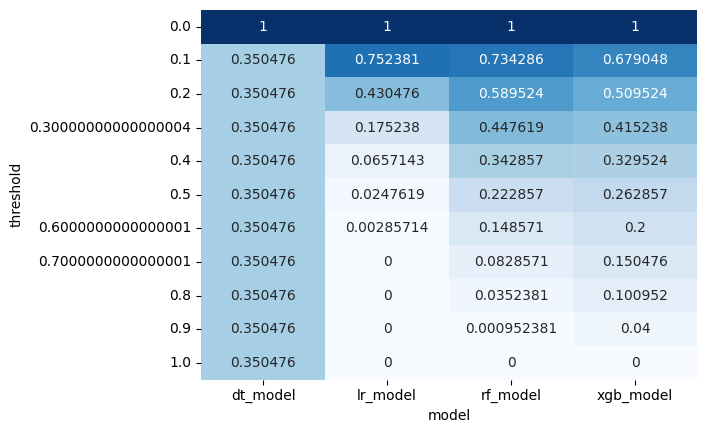

In [49]:
sns.heatmap(df_scores_pivot['recall'], annot=True, fmt="g", cmap='Blues', cbar=False)

<Axes: xlabel='model', ylabel='threshold'>

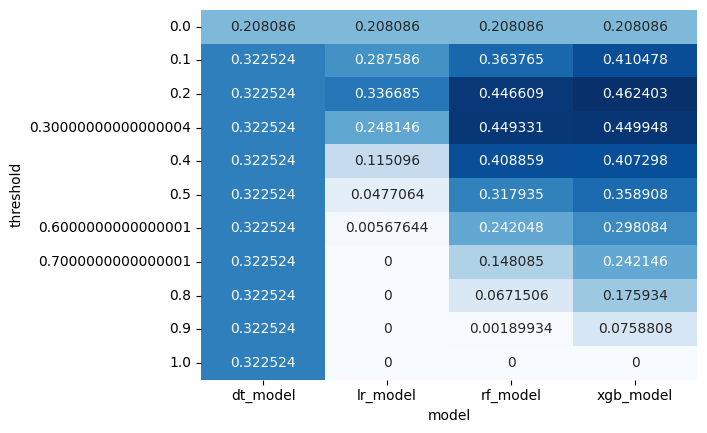

In [50]:
sns.heatmap(df_scores_pivot['f1'], annot=True, fmt="g", cmap='Blues', cbar=False)

<Axes: xlabel='model', ylabel='threshold'>

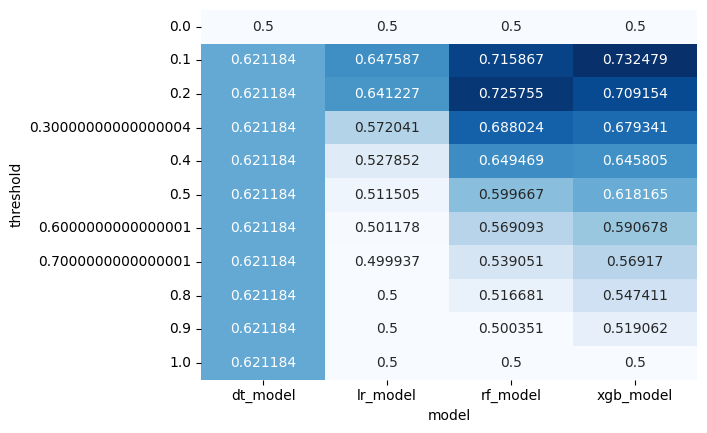

In [51]:
sns.heatmap(df_scores_pivot['roc_auc'], annot=True, fmt="g", cmap='Blues', cbar=False)

Metrics for lr_model:
Accuracy: 0.8852023888520238
Precision: 0.65
Recall: 0.024761904761904763
F1-score: 0.047706422018348627
ROC AUC: 0.5115050765050765


Metrics for dt_model:
Accuracy: 0.8290201282902013
Precision: 0.2987012987012987
Recall: 0.3504761904761905
F1-score: 0.32252410166520595
ROC AUC: 0.6211840411840411


Metrics for rf_model:


Accuracy: 0.8895155938951559
Precision: 0.5635910224438903
Recall: 0.21523809523809523
F1-score: 0.31150930392832527
ROC AUC: 0.5966705991705992


Metrics for xgb_model:
Accuracy: 0.8909533289095333
Precision: 0.5655737704918032
Recall: 0.26285714285714284
F1-score: 0.35890767230169046
ROC AUC: 0.6181653081653081




confusion matrix

Confusion matrix for lr_model:


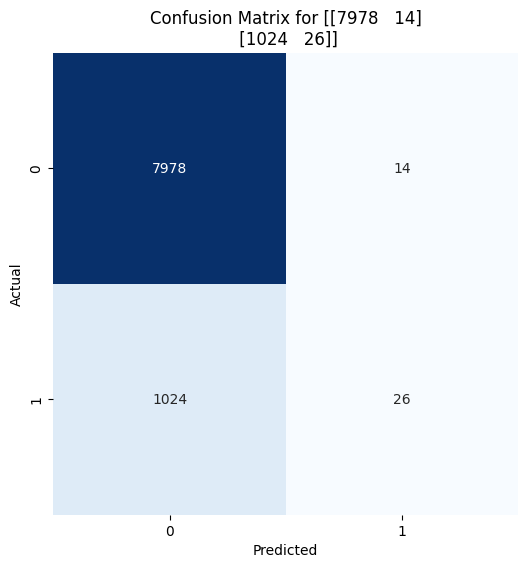

Confusion matrix for dt_model:


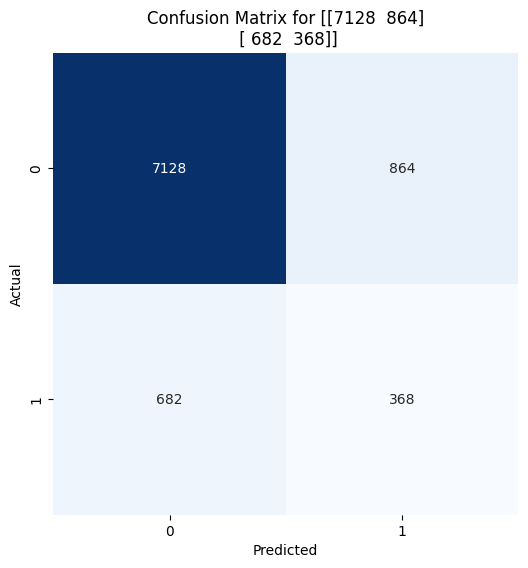

Confusion matrix for rf_model:


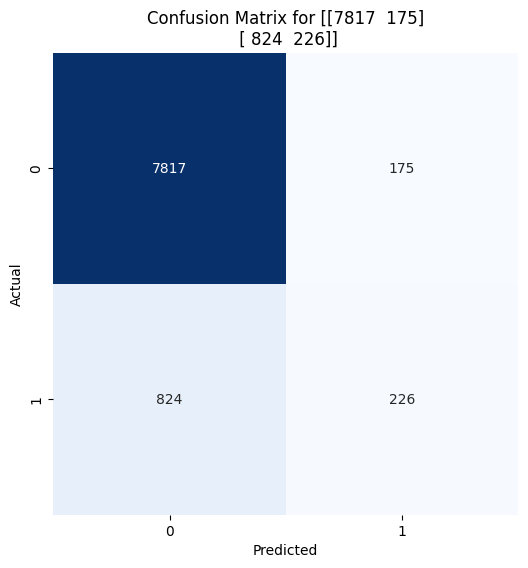

Confusion matrix for xgb_model:


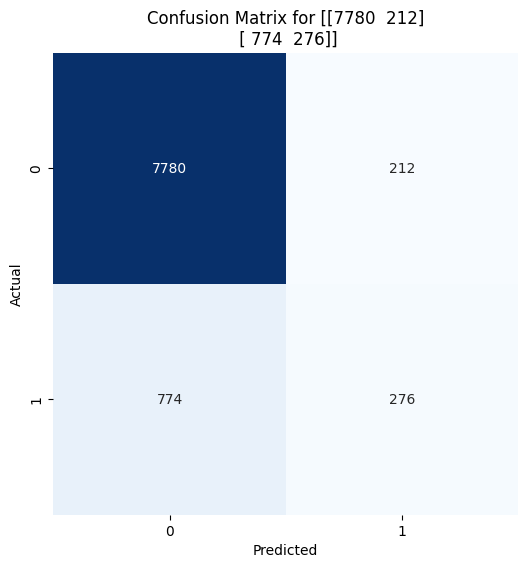

Confusion matrix for Logistic Regression:


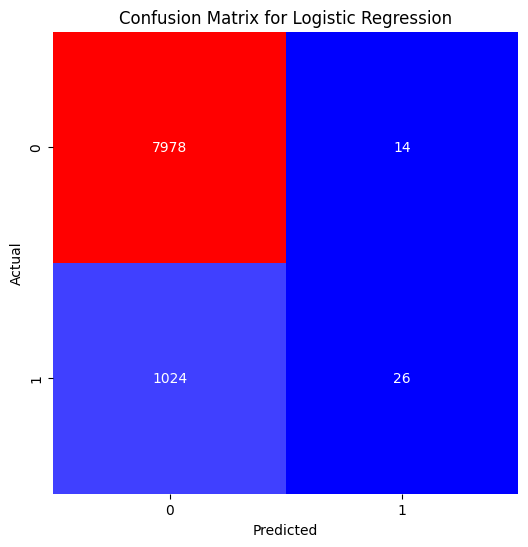

Confusion matrix for Decision Tree:


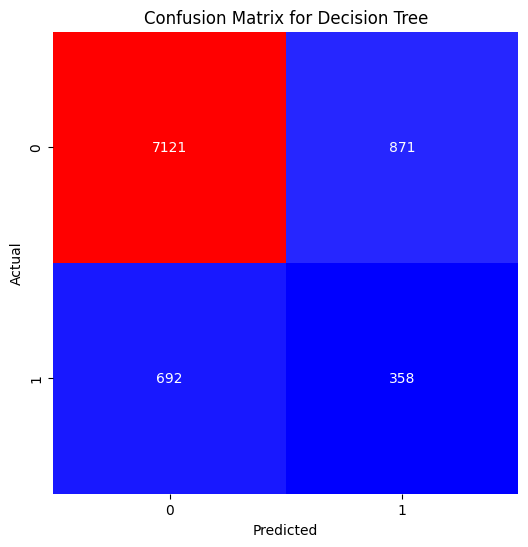

Confusion matrix for Random Forest:


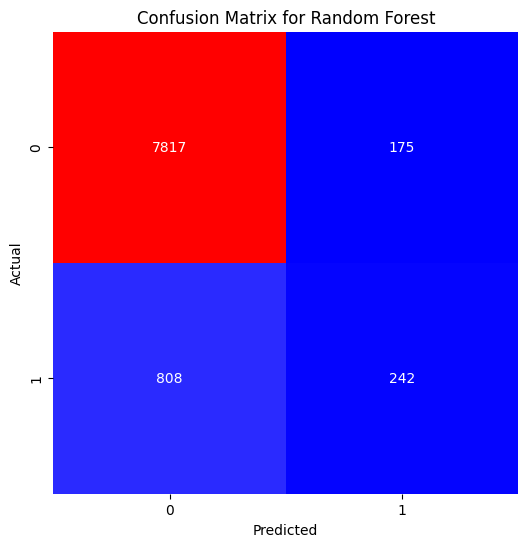

Confusion matrix for XGBoost:


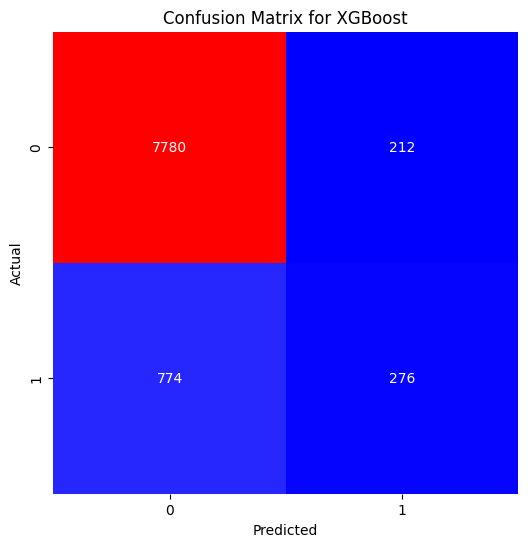

In [6]:


# Evaluate the models
lr_cm = confusion_matrix_evaluation(lr_model, X_val, y_val)
dt_cm = confusion_matrix_evaluation(dt_model, X_val, y_val)
rf_cm = confusion_matrix_evaluation(rf_model, X_val, y_val)
xgb_cm = confusion_matrix_evaluation(xgb_model, X_val, y_val)
all_cm = [lr_cm, dt_cm, rf_cm, xgb_cm]


cm_scores = dict(zip(models, all_cm))

for cm in cm_scores:
    print(f"Confusion matrix for {cm}:")
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))

    sns.heatmap(cm_scores[cm], annot=True, fmt="d", cmap="bwr", cbar=False, 
            xticklabels=[0,1], yticklabels=[0,1])

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {cm}')
    plt.show()

won't be able to create an roc curve for discrete models (those that can only produce a 0/1 prediction). Therefore, I'll discard the roc_curve metric

In [25]:
from sklearn.metrics import roc_curve

In [28]:
# y_pred = dt_model.predict_proba(X_val)[:, 1]
dt_model.predict_proba(X_val)[:, 1]

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [41]:
columns = ['thresholds', 'depth', 'scores']
df_scores = pd.DataFrame(scores, columns=columns)

In [44]:
df_scores

,thresholds,depth,scores
0,0.0,1,0.208086
1,0.0,2,0.208086
2,0.0,3,0.208086
3,0.0,4,0.208086
4,0.0,5,0.208086
...,...,...,...
247,1.0,15,0.290323
248,1.0,20,0.322541
249,1.0,25,0.318158
250,1.0,30,0.313872


<Axes: xlabel='depth', ylabel='thresholds'>

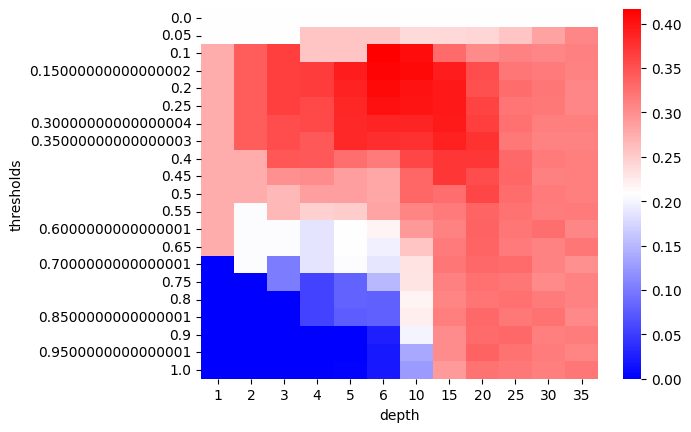

In [49]:
df_scores_pivot = df_scores.pivot_table(index='thresholds', columns='depth', values='scores')
sns.heatmap(df_scores_pivot, cmap='bwr')

In [51]:
df_scores.sort_values(by='scores',ascending=False).head(15)

,thresholds,depth,scores
29,0.10,6,0.416397
41,0.15,6,0.411604
42,0.15,10,0.409222
53,0.20,6,0.409041
30,0.10,10,0.405114
65,0.25,6,0.402027
54,0.20,10,0.400659
66,0.25,10,0.399781
55,0.20,15,0.396462
67,0.25,15,0.395510


In [56]:
from IPython.display import display

In [57]:
display(df_scores)

,thresholds,depth,scores
0,0.0,1,0.208086
1,0.0,2,0.208086
2,0.0,3,0.208086
3,0.0,4,0.208086
4,0.0,5,0.208086
...,...,...,...
247,1.0,15,0.290323
248,1.0,20,0.322541
249,1.0,25,0.318158
250,1.0,30,0.313872


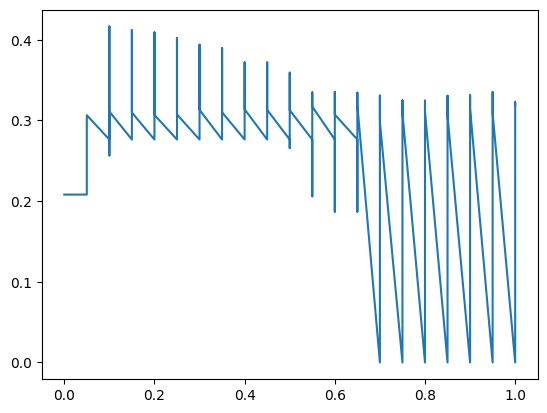

In [61]:
plt.plot(df_scores['thresholds'], df_scores['scores'])

In [70]:
recall_score(y_val, (y_pred >= 0.1).astype(int))

0.3476190476190476

In [71]:
confusion_matrix(y_val, (y_pred >= 0.1).astype(int))

array([[7075,  917],
       [ 685,  365]])

when the model mistakenly predicts 1 instead of 0 it's money lost by the bank  
when the model mistakenly predicts 0 instead of 1 it's a missed opportunity for the bank to make a profit   

precision: tp / (tp + fp) "Of all the instances the model labeled as positive, how many were actually positive?"  
recall: tp / (tp + fn) "Of all the instances that were actually positive, how many did the model correctly identify?"  

low precision = lost money  
low recall = missed opportunity

the bank is more interested in making money than in regulating spending, prioritizing high recall over high precision  
accordingly, we'll focus on the models with higher recall, which are decision trees and xgboost

[0.09760561 0.09760561 0.09760561 ... 0.09760561 0.09760561 0.09760561]
[0.09148671 0.09148671 0.09148671 ... 0.09148671 0.09148671 0.09148671]
[0.08833006 0.08833006 0.08833006 ... 0.08833006 0.08833006 0.08833006]
[0.10966974 0.10966974 0.10966974 ... 0.04001539 0.10966974 0.04001539]
[0.10372001 0.10372001 0.10372001 ... 0.03952772 0.10372001 0.03952772]
[0.09961753 0.09961753 0.09961753 ... 0.0386349  0.09961753 0.0386349 ]
[0.08368766 0.08368766 0.08368766 ... 0.02875399 0.08368766 0.04428044]
[0.0431098  0.06599607 0.14336918 ... 0.01661538 0.11240633 0.04761905]
[0.03003534 0.05424955 0.23809524 ... 0.         0.24137931 0.        ]
[0.75       0.02415459 0.19512195 ... 0.         0.21052632 0.        ]
[0.         0.         0.24324324 ... 0.         0.         0.        ]
[1.         0.         0.05263158 ... 0.         0.         0.        ]
[0. 0. 0. ... 0. 0. 0.]


DecisionTreeClassifier(max_depth=10)

In [17]:
sum(dt.predict(X_val))

449

In [18]:
dt.predict_proba(X_val)

array([[0.91631234, 0.08368766],
       [0.91631234, 0.08368766],
       [0.91631234, 0.08368766],
       ...,
       [0.97124601, 0.02875399],
       [0.91631234, 0.08368766],
       [0.95571956, 0.04428044]])

In [13]:
roc_auc_score(y_val, dt.predict(X_val))

0.6122511797511797

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

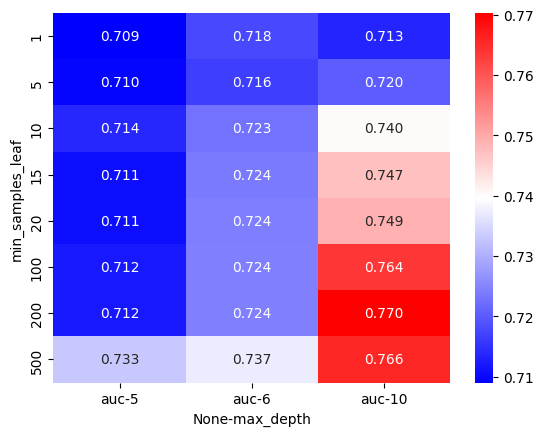

In [ ]:
# Define a function for model evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    return accuracy, precision, recall, f1, roc_auc

In [45]:
scores = []

for depth in [5, 6, 10]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        dt_scores = evaluate_model(dt, X_val, y_val)
        
        scores.append((depth, s)+dt_scores)

In [46]:
columns = ['depth', 'min_sample_leaf', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_sample_leaf', columns=['depth'], values=['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC'])

In [47]:
df_scores_pivot

Accuracy                     Precision                      \
depth                  5         6         10        5         6         10   
min_sample_leaf                                                               
1                0.891285  0.890953  0.889847  0.601824  0.599379  0.560538   
5                0.891064  0.890511  0.890069  0.601246  0.596774  0.576087   
10               0.891285  0.891175  0.890400  0.603077  0.609272  0.587537   
15               0.890179  0.889737  0.889294  0.585075  0.587459  0.567123   
20               0.890511  0.890843  0.890400  0.596774  0.609756  0.578249   
100              0.890843  0.890843  0.891285  0.606061  0.606061  0.601824   
200              0.891064  0.891064  0.891064  0.604502  0.604502  0.604502   
500              0.891064  0.891064  0.891064  0.604502  0.604502  0.604502   

                   Recall                      F1-score                      \
depth                  5         6         10        5         6         10   
min_sample_leaf                                                               
1                0.188571  0.183810  0.238095  0.287165  0.281341  0.334225   
5                0.183810  0.176190  0.201905  0.281546  0.272059  0.299013   
10               0.186667  0.175238  0.188571  0.285091  0.272189  0.285508   
15               0.186667  0.169524  0.197143  0.283032  0.263119  0.292580   
20               0.176190  0.166667  0.207619  0.272059  0.261780  0.305536   
100              0.171429  0.171429  0.188571  0.267261  0.267261  0.287165   
200              0.179048  0.179048  0.179048  0.276267  0.276267  0.276267   
500              0.179048  0.179048  0.179048  0.276267  0.276267  0.276267   

                  ROC AUC                      
depth                  5         6         10  
min_sample_leaf                                
1                0.586090  0.583834  0.606785  
5                0.583897  0.580275  0.591193  
10               0.585263  0.580237  0.585590  
15               0.584637  0.576942  0.588687  
20               0.580275  0.576326  0.593862  
100              0.578394  0.578394  0.586090  
200              0.581829  0.581829  0.581829  
500              0.581829  0.581829  0.581829

In [38]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f", cmap='bwr')

In [ ]:
# dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=200)
# dt.fit(X_train, y_train)

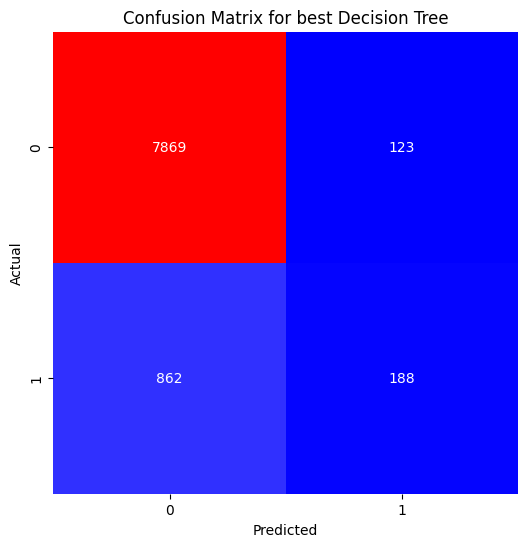

In [14]:
dt_cm = confusion_matrix_evaluation(dt, X_val, y_val)

plt.figure(figsize=(6,6))
sns.heatmap(dt_cm, annot=True, fmt="d", cmap="bwr", cbar=False, xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Confusion Matrix for best Decision Tree')
plt.show()